# Link Prediction Lab

In [1]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
import random as rnd

rnd.seed()

## Graph Input

In [2]:
G = nx.read_edgelist("karate")

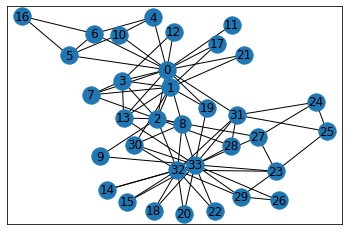

In [3]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G,pos, with_labels=True)
plt.show()

## Computing Common Neighbors Score

We define the "common neighbours" link score:

In [4]:
def common_neighbors(G,i,j):
    # G - the graph
    # i,j - the link
    return len(set(G.neighbors(i)) and set(G.neighbors(j)))

In [5]:
common_neighbors(G,'31','17')

2

## Link Prediction

We define a function which returns a sorted list of of scores from a node to other possible nodes in the graph:

In [6]:
def link_list(G,i,score_func):
    # G - the graph
    # i - the node
    # score_func - the link scoring function, having the signature score_func(G,i,j)
    links = []
    for j in G.nodes():
        if not G.has_edge(i,j) and i!=j:
            e = (i,j)
            sc = score_func(G,i,j)
            links.append([e,sc])
    links.sort(key = lambda x: x[1], reverse = True) 
    return links

In [7]:
link_list(G,'31',common_neighbors)

[[('31', '2'), 10],
 [('31', '1'), 9],
 [('31', '3'), 6],
 [('31', '13'), 5],
 [('31', '8'), 5],
 [('31', '23'), 5],
 [('31', '7'), 4],
 [('31', '6'), 4],
 [('31', '5'), 4],
 [('31', '30'), 4],
 [('31', '27'), 4],
 [('31', '29'), 4],
 [('31', '19'), 3],
 [('31', '10'), 3],
 [('31', '4'), 3],
 [('31', '21'), 2],
 [('31', '17'), 2],
 [('31', '12'), 2],
 [('31', '9'), 2],
 [('31', '16'), 2],
 [('31', '14'), 2],
 [('31', '15'), 2],
 [('31', '18'), 2],
 [('31', '20'), 2],
 [('31', '22'), 2],
 [('31', '26'), 2],
 [('31', '11'), 1]]

### scoring function

In [8]:
# jacard coeff
def jacard_coeff_score(G,i,j):
    # G - the graph
    # i,j - the link
    return len(set(G.neighbors(i)).intersection(set(G.neighbors(j))))/len(set(G.neighbors(i)).union(set(G.neighbors(j))))

#preferential attachement
def pref_attachement(G,i,j):
    # G - the graph
    # i,j - the link
    return nx.degree(G, nbunch=i, weight=None)*nx.degree(G, nbunch=j, weight=None)

# distance score
def inverse_distance_score(G,i,j):
    # G - the graph
    # i,j - the link
    d = 1000
    try:
        d = nx.shortest_path_length(G, source=i, target=j, weight=None, method='dijkstra')
    except:
        pass
    
    return 1/d

#page rank approche personelized i
def page_rank_score_b(G,i,j):
    # G - the graph
    # i,j - the link
    personal = {i:0 for i in G.nodes()}
    personal[i] = 1

    return nx.pagerank(G, alpha=0.2, personalization=personal, max_iter=100, tol=1e-06, weight='weight', dangling=None)[j]

#page symetric implementation with page rank
def page_rank_score_a(G,i,j):
    # G - the graph
    # i,j - the link
    personal = {i:0 for i in G.nodes()}
    personal[i] = 0.5
    personal[j] = 0.5
    
    return (nx.pagerank(G, alpha=0.2, personalization=personal, max_iter=100, tol=1e-06, weight='weight', dangling=None)[j]+
nx.pagerank(G, alpha=0.2, personalization=personal, max_iter=100, tol=1e-06, weight='weight', dangling=None)[j])/2

def random_score(G,i,j):
    # G - the graph
    # i,j - the link
    return rnd.random()

In [9]:
print(jacard_coeff_score(G,'33','32'))
inverse_distance_score(G,'20','26')

0.5263157894736842


0.5

In [10]:
page_rank_score_a(G,'31','30')

0.4023434475116328

In [11]:
page_rank_score_b(G,'31','30')

0.0008855877122513162

## 3 - Link prediction

In [12]:
def link_prediction(G,k,i,score_func):
    ls = link_list(G,i,score_func)
    perdiction = ls[0:k]
    links = [i[0] for i in perdiction]
    return links

In [13]:
link_prediction(G,3,'31',page_rank_score_a)

[('31', '6'), ('31', '5'), ('31', '2')]

In [14]:

def guessing(G,k,score_func):
    g_tmp = G.copy()
    
    edge_removed = None
    while edge_removed == None:
        for edge in g_tmp.edges():
            if rnd.random()<0.03:
                edge_removed = edge
                break
                
    g_tmp.remove_edge(edge_removed[0],edge_removed[1])
    
    prediction = link_prediction(g_tmp,k,edge_removed[0],score_func)
    
    #print(prediction)
    #print(edge_removed)
    
    return edge_removed in prediction
  
    

            

In [15]:
guessing(G,5,inverse_distance_score)


False

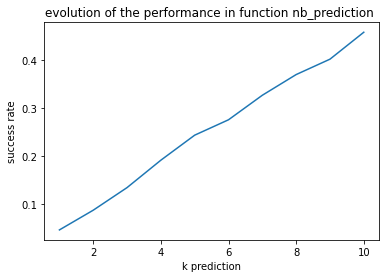

In [16]:
functions = [jacard_coeff_score,common_neighbors,pref_attachement,inverse_distance_score,page_rank_score_b,page_rank_score_a,random_score]

# statistivl experice 
nb_try = 1000

k_vals = [i+1 for i in range(0,10)]

prediction_success = []

#function 1 
for k in k_vals:
    correct = 0
    wrong = 0
    for _ in range(0,nb_try):
        if guessing(G,k,random_score):
            correct+=1
        else:
            wrong+=1
    prediction_success.append(correct/(correct+wrong))
    
plt.xlabel('k prediction')
plt.ylabel('success rate')
plt.title('evolution of the performance in function nb_prediction ');
plt.plot(k_vals,prediction_success)
    

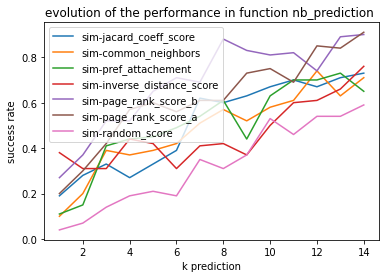

In [24]:
plt.xlabel('k prediction')
plt.ylabel('success rate')
plt.title('evolution of the performance in function nb_prediction ');
full_data = []

for function in functions:
    
    k_vals = [i+1 for i in range(0,14)]

    prediction_success = []

    #function 1 
    for k in k_vals:
        correct = 0
        wrong = 0
        for _ in range(0,100):
            if guessing(G,k,function):
                correct+=1
            else:
                wrong+=1
        
        #print(correct/(correct+wrong))
        prediction_success.append(correct/(correct+wrong))
    
    #print(prediction_success)
    full_data.append(prediction_success)
    plt.plot(k_vals,prediction_success,label="sim-"+function.__name__)

plt.legend(loc='upper left')

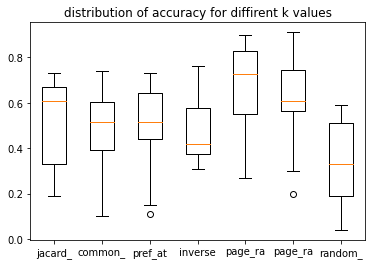

In [36]:

names = [f.__name__[0:7] for f in functions]
ids = [i+1 for i in range(0,len(functions))]


plt.title('distribution of accuracy for diffirent k values')
plt.boxplot(full_data)

plt.xticks(ids, names)

plt.show()
